## **Capstone Project - The Battle of Neighborhoods** ##  
#### **_/ choosing the best place to open a fitness center in the Central administrative borough of Moscow /_** ####
Import Libraries
In this section we import the libraries that will be required to process the data.
The first library is Pandas. Pandas is an open source, BSD-licensed library, providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [2]:
with open('data-4275-2021-06-01.json') as json_data:
    msk_data = json.load(json_data)

In [3]:
column_names = ['Borough', 'Neighborhood', 'sLatitude', 'sLongitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

In [4]:
def convert_cyrillic_district(value):
    ### since the task is performed in English, we need the function of converting the name of the district 
    ### from Russian to English. The function also removes unnecessary words, 
    ### leaving only the name of the administrative district. 
    name = ''
    value = value.replace(' административный округ', '')
    if value == 'Центральный': name = 'Central'
    elif value == 'Восточный': name = 'Eastern'
    elif value == 'Северо-Восточный': name = 'Northeast'
    elif value == 'Северный': name = 'Northern'
    elif value == 'Северо-Западный': name = 'Northwest'
    elif value == 'Западный': name = 'Western'
    elif value == 'Юго-Западный': name = 'Southwest'
    elif value == 'Южный': name = 'Southern'
    elif value == 'Юго-Восточный': name = 'Southeast'
    elif value == 'Зеленоградский': name = 'Zelenogradskiy'
    elif value == 'Новомосковский': name = 'Novomoskovskiy'
    elif value == 'Троицкий': name = 'Troitsky'
    else: value == 'Not assigned'
    return name

In [5]:
#!pip install transliterate
import transliterate as tr

def convert_cyrillic_to_latin(value):
    value = value.replace(' район', '').replace('район ', '')
    name = tr.translit(value, 'ru', reversed=True)
    return name

def translit_df(s):
    s = tr.translit(s, 'ru', reversed=True)
    return s

In [6]:
def toFixed(f: str, n=0):
    a, b = f.split('.')
    return float('{}.{}{}'.format(a, b[:n], '0'*(n-len(b))))

In [7]:
for data in msk_data:
    borough =  convert_cyrillic_district(data['AdmArea'])
    neighborhood = convert_cyrillic_to_latin(data['District'])
    latitude = toFixed(data['Latitude_WGS84'], 6)
    #Flatitude = float(latitude)
    longitude = toFixed(data['Longitude_WGS84'], 6)
    #print(type(longitude))
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood,
                                          'sLatitude': latitude,
                                          'sLongitude': longitude}, ignore_index=True)

In [8]:
neighborhoods.to_pickle('msk_neighborhoods.pkl')

In [9]:
neighborhoods.head()

,Borough,Neighborhood,sLatitude,sLongitude
0,Northeast,Jaroslavskij,55.879001,37.714565
1,Central,Taganskij,55.738238,37.673306
2,Central,Taganskij,55.735511,37.669647
3,Northeast,Lianozovo,55.904018,37.566940
4,Central,Arbat,55.747390,37.598127


In [10]:
neighborhoods.shape

(17298, 4)

In [11]:
# calculate the averaged coordinates for each Neighborhood based on the set of points in the dataset
neighborhoods['idx']=neighborhoods['Neighborhood']
neighborhoods=neighborhoods.set_index('idx')
neighborhoods['Latitude']=neighborhoods['sLatitude'].groupby('idx').mean()
neighborhoods['Longitude']=neighborhoods['sLongitude'].groupby('idx').mean()
neighborhoods.drop(["sLatitude","sLongitude"], axis=1, inplace=True)

In [12]:
df = neighborhoods.drop_duplicates(subset=['Borough', 'Neighborhood'])

In [13]:
df = df.set_index(np.arange(len(df.index)))
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Northeast,Jaroslavskij,55.864151,37.697785
1,Central,Taganskij,55.741998,37.662322
2,Northeast,Lianozovo,55.900109,37.568415
3,Central,Arbat,55.750998,37.592153
4,Southeast,Lefortovo,55.752483,37.707171


In [14]:
df.shape

(146, 4)

In [15]:
address = 'Moscow, RU'

In [16]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moscow City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Moscow City are 55.7504461, 37.6174943.


In [17]:
central_data = df[df['Borough'] == 'Central'].reset_index(drop=True)
central_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Central,Taganskij,55.741998,37.662322
1,Central,Arbat,55.750998,37.592153
2,Central,Meschanskij,55.771993,37.627735
3,Central,Basmannyj,55.763280,37.656543
4,Central,Zamoskvorech'e,55.735110,37.632451
5,Central,Presnenskij,55.758716,37.567657
6,Central,Tverskoj,55.769039,37.606422
7,Central,Hamovniki,55.732433,37.580824
8,Central,Krasnosel'skij,55.773847,37.650063
9,Central,Jakimanka,55.732413,37.613099


In [33]:
import folium
# create map of Moscow using latitude and longitude values
map_msk = folium.Map(location=[latitude, longitude], tiles='Stamen Terrain', zoom_start=10)
#map_data = neighborhoods[neighborhoods['Borough'] == 'Central'].reset_index(drop=True)
map_data = central_data
# add markers to map
for lat, lng, borough, neighborhood in zip(map_data['Latitude'], map_data['Longitude'], map_data['Borough'], map_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_msk)  
    
map_msk

## **Foursquare venues** ##

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius, categoryIds=''):
    try:
        LIMIT=100
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            print(name)
            
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)
                
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)   
    return(nearby_venues)

In [47]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
CATEGORY_ID = '4bf58dd8d48988d175941735' #Gym / Fitness Center

**Now write the code to run the above function on each neighborhood and create a new dataframe called msk_venues.**

In [48]:
df = df[df['Borough'] == 'Central'].reset_index(drop=True)
msk_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=1000, categoryIds=CATEGORY_ID)
msk_venues.head()

Taganskij
Arbat
Meschanskij
Basmannyj
Zamoskvorech'e
Presnenskij
Tverskoj
Hamovniki
Krasnosel'skij
Jakimanka


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Taganskij,55.741998,37.662322,La Salute,55.743409,37.656018,Gym / Fitness Center
1,Taganskij,55.741998,37.662322,ФОК в Парке «Таганский»,55.738409,37.666063,Gym / Fitness Center
2,Taganskij,55.741998,37.662322,World Class,55.747110,37.657317,Gym / Fitness Center
3,Taganskij,55.741998,37.662322,Тренажерный Зал МТТ,55.738093,37.660673,Gym / Fitness Center
4,Taganskij,55.741998,37.662322,спортзал Среднерусского банка,55.744838,37.669034,Gym / Fitness Center


Translation of the name Venue from Cyrillic into Latin

In [49]:
msk_venues['Venue'] = msk_venues['Venue'].apply(translit_df)
msk_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Taganskij,55.741998,37.662322,La Salute,55.743409,37.656018,Gym / Fitness Center
1,Taganskij,55.741998,37.662322,FOK v Parke «Taganskij»,55.738409,37.666063,Gym / Fitness Center
2,Taganskij,55.741998,37.662322,World Class,55.747110,37.657317,Gym / Fitness Center
3,Taganskij,55.741998,37.662322,Trenazhernyj Zal MTT,55.738093,37.660673,Gym / Fitness Center
4,Taganskij,55.741998,37.662322,sportzal Srednerusskogo banka,55.744838,37.669034,Gym / Fitness Center


**Let's check the size of the resulting dataframe**

In [50]:
msk_venues.shape

(269, 7)

In [51]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.4).add_to(existingMap)

In [52]:
map_msk_res = folium.Map(location=[latitude, longitude], zoom_start=12) #, tiles='Stamen Terrain' tiles='Stamen Watercolor',
addToMap(msk_venues, 'red', map_msk_res)

map_msk_res

In [27]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0


In [53]:
msk_grouped = msk_venues.groupby('Neighborhood').count()
msk_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arbat,34,34,34,34,34,34
Basmannyj,32,32,32,32,32,32
Hamovniki,21,21,21,21,21,21
Jakimanka,20,20,20,20,20,20
Krasnosel'skij,12,12,12,12,12,12
Meschanskij,21,21,21,21,21,21
Presnenskij,28,28,28,28,28,28
Taganskij,21,21,21,21,21,21
Tverskoj,48,48,48,48,48,48


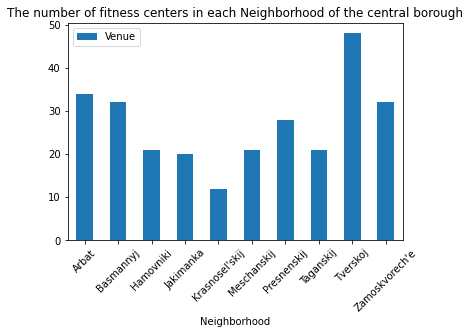

In [63]:
# Draw a vertical bar chart
ax = msk_grouped.plot.bar( y="Venue", rot=45, title="The number of fitness centers in each Neighborhood of the central borough")

## **Analyze Each Neighborhood** ##

In [64]:
# one hot encoding
central_onehot = pd.get_dummies(msk_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
central_onehot['Neighborhood'] = msk_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [central_onehot.columns[-1]] + list(central_onehot.columns[:-1])
central_onehot = central_onehot[fixed_columns]

central_onehot.head()

,Neighborhood,Arts & Entertainment,Boxing Gym,Cycle Studio,Dance Studio,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Martial Arts School,Massage Studio,Pilates Studio,Pool,Salon / Barbershop,Soccer Field,Tennis Court,Track,Yoga Studio
0,Taganskij,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Taganskij,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Taganskij,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Taganskij,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,Taganskij,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


**And let's examine the new dataframe size.**

In [65]:
central_onehot.shape

(269, 19)

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [67]:
central_grouped = central_onehot.groupby('Neighborhood').mean().reset_index()
central_grouped

,Neighborhood,Arts & Entertainment,Boxing Gym,Cycle Studio,Dance Studio,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Martial Arts School,Massage Studio,Pilates Studio,Pool,Salon / Barbershop,Soccer Field,Tennis Court,Track,Yoga Studio
0,Arbat,0.000000,0.029412,0.029412,0.029412,0.029412,0.382353,0.000000,0.058824,0.000000,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.352941
1,Basmannyj,0.000000,0.000000,0.000000,0.000000,0.125000,0.468750,0.000000,0.000000,0.000000,0.093750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.312500
2,Hamovniki,0.047619,0.000000,0.000000,0.000000,0.142857,0.380952,0.047619,0.047619,0.000000,0.047619,0.000000,0.047619,0.047619,0.000000,0.000000,0.000000,0.047619,0.142857
3,Jakimanka,0.000000,0.050000,0.000000,0.000000,0.050000,0.400000,0.100000,0.050000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.250000
4,Krasnosel'skij,0.000000,0.000000,0.000000,0.000000,0.083333,0.583333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
5,Meschanskij,0.000000,0.000000,0.000000,0.000000,0.095238,0.238095,0.000000,0.047619,0.047619,0.142857,0.047619,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.333333
6,Presnenskij,0.000000,0.107143,0.000000,0.035714,0.035714,0.535714,0.000000,0.000000,0.000000,0.071429,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.035714,0.142857
7,Taganskij,0.000000,0.047619,0.000000,0.000000,0.047619,0.476190,0.000000,0.095238,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.047619,0.142857
8,Tverskoj,0.000000,0.041667,0.020833,0.020833,0.020833,0.395833,0.041667,0.125000,0.000000,0.041667,0.000000,0.020833,0.000000,0.000000,0.000000,0.020833,0.000000,0.250000
9,Zamoskvorech'e,0.000000,0.000000,0.000000,0.000000,0.156250,0.312500,0.031250,0.062500,0.000000,0.093750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.281250


**Let's confirm the new size**

In [68]:
central_grouped.shape

(10, 19)

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Now let's create the new dataframe and display the top 10 venues for each neighborhood.**

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = central_grouped['Neighborhood']

for ind in np.arange(central_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(central_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbat,Gym / Fitness Center,Yoga Studio,Martial Arts School,Gymnastics Gym,Dance Studio,Gym,Cycle Studio,Boxing Gym,Gym Pool,Health & Beauty Service
1,Basmannyj,Gym / Fitness Center,Yoga Studio,Gym,Martial Arts School,Dance Studio,Cycle Studio,Gym Pool,Gymnastics Gym,Health & Beauty Service,Boxing Gym
2,Hamovniki,Gym / Fitness Center,Yoga Studio,Gym,Gymnastics Gym,Track,Pool,Pilates Studio,Arts & Entertainment,Gym Pool,Martial Arts School
3,Jakimanka,Gym / Fitness Center,Yoga Studio,Gym Pool,Track,Boxing Gym,Gymnastics Gym,Martial Arts School,Gym,Health & Beauty Service,Dance Studio
4,Krasnosel'skij,Gym / Fitness Center,Yoga Studio,Gym,Martial Arts School,Dance Studio,Cycle Studio,Gym Pool,Gymnastics Gym,Health & Beauty Service,Boxing Gym


## **Cluster Neighborhoods** ##  
**Run k-means to cluster the neighborhood into 5 clusters.**

In [72]:
# set number of clusters
kclusters = 5

central_grouped_clustering = central_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(central_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([2, 0, 3, 2, 0, 1, 4, 4, 2, 1])

**Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.**

In [73]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

central_merged = central_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
central_merged = central_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

central_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central,Taganskij,55.741998,37.662322,4,Gym / Fitness Center,Yoga Studio,Gymnastics Gym,Track,Soccer Field,Salon / Barbershop,Boxing Gym,Martial Arts School,Gym,Health & Beauty Service
1,Central,Arbat,55.750998,37.592153,2,Gym / Fitness Center,Yoga Studio,Martial Arts School,Gymnastics Gym,Dance Studio,Gym,Cycle Studio,Boxing Gym,Gym Pool,Health & Beauty Service
2,Central,Meschanskij,55.771993,37.627735,1,Yoga Studio,Gym / Fitness Center,Martial Arts School,Gym,Gymnastics Gym,Health & Beauty Service,Massage Studio,Tennis Court,Dance Studio,Cycle Studio
3,Central,Basmannyj,55.763280,37.656543,0,Gym / Fitness Center,Yoga Studio,Gym,Martial Arts School,Dance Studio,Cycle Studio,Gym Pool,Gymnastics Gym,Health & Beauty Service,Boxing Gym
4,Central,Zamoskvorech'e,55.735110,37.632451,1,Gym / Fitness Center,Yoga Studio,Gym,Martial Arts School,Gymnastics Gym,Track,Gym Pool,Dance Studio,Cycle Studio,Health & Beauty Service


**Finally, let's visualize the resulting clusters**

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude],# tiles='Stamen Terrain',
                          zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(central_merged['Latitude'], central_merged['Longitude'], central_merged['Neighborhood'], central_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### **Cluster 0**

In [158]:
central_merged.loc[central_merged['Cluster Labels'] == 0, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Zamoskvorech'e,Gym / Fitness Center,Yoga Studio,Gym,Track,Dance Studio,Sports Club,Gymnastics Gym,Soccer Field,Tennis Court,Spiritual Center
8,Krasnosel'skij,Gym / Fitness Center,Yoga Studio,Gym,Track,Spiritual Center,Boxing Gym,Pool,Tennis Court,Sports Club,Spa
9,Jakimanka,Gym / Fitness Center,Yoga Studio,Gym,Track,Dance Studio,Sports Club,Outdoor Gym,Soccer Field,Tennis Court,Spiritual Center


### **Cluster 1**

In [159]:
central_merged.loc[central_merged['Cluster Labels'] == 1, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arbat,Gym / Fitness Center,Yoga Studio,Gym,Martial Arts School,Track,Gymnastics Gym,Boxing Gym,Spa,Soccer Field,Tennis Court
2,Meschanskij,Gym / Fitness Center,Gym,Yoga Studio,Gymnastics Gym,Tennis Court,Outdoor Gym,Boxing Gym,Martial Arts School,Massage Studio,Gym Pool
3,Basmannyj,Gym / Fitness Center,Yoga Studio,Gym,Martial Arts School,Spiritual Center,Boxing Gym,Soccer Field,Track,Tennis Court,Sports Club


### **Cluster 2**

In [160]:
central_merged.loc[central_merged['Cluster Labels'] == 2, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Presnenskij,Gym / Fitness Center,Yoga Studio,Gym,Track,Sports Club,Spa,Martial Arts School,Outdoor Gym,Soccer Field,Tennis Court
6,Tverskoj,Gym / Fitness Center,Yoga Studio,Gymnastics Gym,Cycle Studio,Tennis Court,Gym,Martial Arts School,Boxing Gym,Spa,Social Club


### **Cluster 3**

In [161]:
central_merged.loc[central_merged['Cluster Labels'] == 3, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Taganskij,Gym / Fitness Center,Yoga Studio,Martial Arts School,College Gym,Cycle Studio,Track,Gym,Gym Pool,Gymnastics Gym,Boxing Gym


### **Cluster 4**

In [162]:
central_merged.loc[central_merged['Cluster Labels'] == 4, central_merged.columns[[1] + list(range(5, central_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Hamovniki,Gym / Fitness Center,Yoga Studio,Gym,Outdoor Gym,Gymnastics Gym,Boxing Gym,Track,Social Club,Pool,Arts & Entertainment


## **Thank you !**
This notebook was created by *_Dmitry Rabotko_.*  
This notebook  of a course on **Coursera** called _IBM Applied Data Science Capstone_ Week 5.  
Attention, the research results are educational material and cannot be used in the real business, but the method itself can.